In [1]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *
import timm

In [2]:
!nvidia-smi

Mon Mar  1 16:00:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 46%   84C    P2   203W / 250W |  10919MiB / 10989MiB |     50%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 53%   85C    P2   219W / 250W |  10280MiB / 10989MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
path = Path('datasetPrueba/')
trainPath = path/'train'
testPath = path/'test'

In [4]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = [Resize(presize)],
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=180,pad_mode=PadMode.Zeros), Normalize.from_stats(*imagenet_stats)])

In [5]:
db512 = getDataBlock(512,256)
dls512 = db512.dataloaders(trainPath,bs=64)

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnet_b0'),
    MixUp(),
]

In [7]:
learn = timm_learner(dls512, 'efficientnet_b0',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /home/jonathan/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


SuggestedLRs(lr_min=0.2754228591918945, lr_steep=2.290867567062378)

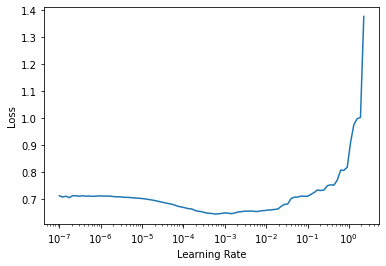

In [9]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.099123,0.666414,0.682559,0.746289,0.620651,00:22


Better model found at epoch 0 with valid_loss value: 0.6664136052131653.


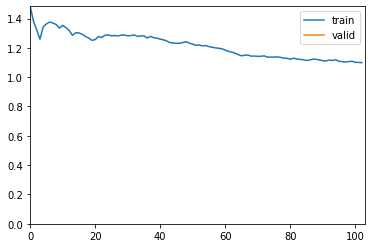

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.998667,0.630947,0.695836,0.755614,0.641975,00:26
1,0.959181,0.617560,0.696439,0.755937,0.643098,00:26
2,0.937806,0.593854,0.712130,0.773087,0.657688,00:26
3,0.935098,0.583013,0.712734,0.772668,0.659933,00:26
4,0.902466,0.574996,0.712130,0.767442,0.666667,00:26
5,0.901535,0.553281,0.721183,0.770492,0.685746,00:26
6,0.896160,0.553120,0.720579,0.762899,0.696970,00:26
7,0.889769,0.546074,0.730839,0.766467,0.718294,00:26
8,0.907208,0.529679,0.730839,0.767107,0.717172,00:26
9,0.876704,0.523537,0.736270,0.778870,0.711560,00:26


Better model found at epoch 0 with valid_loss value: 0.6309471130371094.


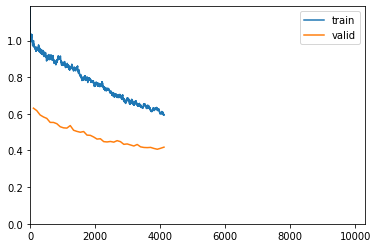

Better model found at epoch 1 with valid_loss value: 0.6175596117973328.
Better model found at epoch 2 with valid_loss value: 0.5938543677330017.
Better model found at epoch 3 with valid_loss value: 0.5830132365226746.
Better model found at epoch 4 with valid_loss value: 0.5749955773353577.
Better model found at epoch 5 with valid_loss value: 0.553281307220459.
Better model found at epoch 6 with valid_loss value: 0.5531203150749207.
Better model found at epoch 7 with valid_loss value: 0.5460741519927979.
Better model found at epoch 8 with valid_loss value: 0.5296793580055237.
Better model found at epoch 9 with valid_loss value: 0.5235369205474854.
Better model found at epoch 10 with valid_loss value: 0.5221668481826782.
Better model found at epoch 12 with valid_loss value: 0.5104386210441589.
Better model found at epoch 13 with valid_loss value: 0.5041806101799011.
Better model found at epoch 14 with valid_loss value: 0.49959588050842285.
Better model found at epoch 16 with valid_loss 

In [8]:
learn.fine_tune(100,base_lr=1e-4)

In [9]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [10]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [11]:
db512 = getDataBlock(512,256)
dls512 = db512.dataloaders(trainPath,bs=64)

In [12]:
learn.freeze()

In [13]:
learn.dls=dls512

In [14]:
#learn.load('hrnet')

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

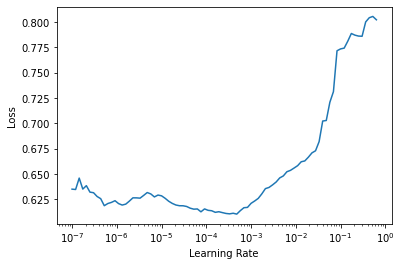

In [16]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.930878,0.735524,0.593272,0.569149,0.672956,00:11


Better model found at epoch 0 with valid_loss value: 0.7355242371559143.


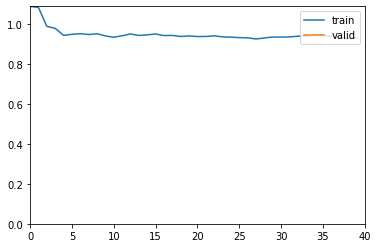

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.912121,0.731630,0.590214,0.569444,0.644654,00:12
1,0.919933,0.733792,0.587156,0.565574,0.650943,00:12
2,0.926353,0.733450,0.588685,0.567493,0.647799,00:12
3,0.908174,0.730545,0.584098,0.564972,0.628931,00:12
4,0.913505,0.738021,0.577982,0.558333,0.632075,00:12
5,0.904684,0.719748,0.594801,0.573003,0.654088,00:12
6,0.891529,0.713165,0.599388,0.580925,0.632075,00:12
7,0.902291,0.706315,0.596330,0.572973,0.666667,00:12
8,0.895516,0.719939,0.599388,0.574468,0.679245,00:12
9,0.910337,0.704482,0.607034,0.585434,0.657233,00:12


Better model found at epoch 0 with valid_loss value: 0.7316299676895142.


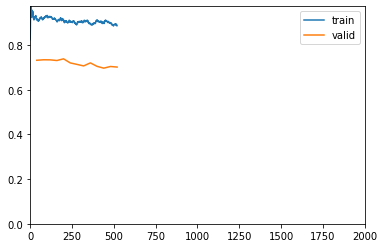

Better model found at epoch 3 with valid_loss value: 0.7305447459220886.
Better model found at epoch 5 with valid_loss value: 0.7197482585906982.
Better model found at epoch 6 with valid_loss value: 0.7131653428077698.
Better model found at epoch 7 with valid_loss value: 0.7063149809837341.
Better model found at epoch 9 with valid_loss value: 0.7044824957847595.
Better model found at epoch 10 with valid_loss value: 0.6963286995887756.
No improvement since epoch 10: early stopping


In [15]:
learn.fine_tune(50,base_lr=1e-5)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5745721459388733.


(#4) [0.7053244113922119,0.5745721459388733,0.5857988165680473,0.6827586206896552]